## 1. Carga de Datos y Preprocesamiento Avanzado

En este primer paso, cargamos nuestro conjunto de datos limpio (`cleaned_train.csv`). Luego, aplicamos una serie de transformaciones y codificaciones avanzadas para preparar los datos para los modelos de Machine Learning. Estas acciones están basadas en los hallazgos de tu Análisis Exploratorio de Datos (EDA) para manejar distribuciones sesgadas, *outliers* y variables categóricas de forma efectiva. Finalmente, dividiremos los datos en conjuntos de entrenamiento y prueba.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
!pip install category_encoders # Install the missing library
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib # Para guardar modelos y transformadores

print("Librerías importadas exitosamente.")

# --- Cargar el Dataset ---
# Cargamos el archivo CSV que contiene nuestros datos limpios de entrenamiento.
df = pd.read_csv('/content/cleaned_train.csv')
print("\nDataset de entrenamiento cargado exitosamente. Primeras 5 filas:")
print(df.head(4))

# --- Transformaciones Logarítmicas y Winsorización ---
# Aplicamos logaritmo (usando log1p para manejar posibles ceros) y winsorización
# a columnas numéricas clave para reducir el sesgo y manejar outliers.
columns_to_transform = ['price', 'milage', 'horsepower', 'car_age']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])
    # La winsorización se aplica para "tapar" los valores extremos (outliers).
    # Los límites (0.05, 0.05) significan que se cortan el 5% inferior y el 5% superior de los valores.
    df[col] = winsorize(df[col], limits=(0.05, 0.05))
print("\nTransformaciones logarítmicas y winsorización aplicadas a columnas especificadas.")

# --- Manejo de Multicolinealidad ---
# Eliminamos columnas identificadas en el EDA como redundantes o que causan multicolinealidad.
# 'model_year' está correlacionado con 'car_age', y 'engine_size_L' con 'horsepower'/'cylinders'.
df = df.drop(columns=['model_year', 'engine_size_L'], errors='ignore')
print("\nColumnas 'model_year' y 'engine_size_L' eliminadas para manejar multicolinealidad.")

# --- Codificación de Variables Categóricas ---
# **Target Encoding para 'brand':** Ideal para variables con muchas categorías.
# Reemplaza cada categoría con el promedio del valor objetivo (price) para esa categoría.
encoder_brand = ce.TargetEncoder(cols=['brand'])
df['brand'] = encoder_brand.fit_transform(df['brand'], df['price'])
print("\nTarget Encoding aplicado a la columna 'brand'.")

# **One-Hot Encoding para otras categóricas:** Para variables con menos categorías únicas.
# Identificamos las columnas que aún son de tipo 'object' (texto) y aplicamos One-Hot Encoding.
categorical_cols_ohe = df.select_dtypes(include='object').columns.tolist()

# Definimos nuestra variable objetivo (Y) y nuestras características (X).
# Y es 'price', X es el resto.
Y = df['price']
X = df.drop('price', axis=1)

# Usamos ColumnTransformer para aplicar One-Hot Encoding solo a las columnas categóricas en X.
# 'remainder=\'passthrough\'' asegura que las columnas numéricas no se vean afectadas.
if categorical_cols_ohe:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_ohe)
        ],
        remainder='passthrough'
    )
    X = preprocessor.fit_transform(X)
    print("\nOne-Hot Encoding aplicado a las columnas categóricas restantes en X.")
else:
    print("\nNo hay columnas categóricas adicionales para One-Hot Encoding.")

print("\nVariables objetivo (Y) y características (X) definidas y preparadas.")

# --- División de Datos en Entrenamiento y Prueba ---
# Dividimos los datos para entrenar el modelo con una parte y evaluarlo con datos no vistos.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("\nDatos divididos en conjuntos de entrenamiento (80%) y prueba (20%).")
print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}, y_test: {y_test.shape}")

Librerías importadas exitosamente.

Dataset de entrenamiento cargado exitosamente. Primeras 5 filas:
       brand  model_year  milage      fuel_type  \
0       MINI        2007  213000       Gasoline   
1    Lincoln        2002  143250       Gasoline   
2  Chevrolet        2002  136731  E85 Flex Fuel   
3    Genesis        2017   19500       Gasoline   

                                 accident clean_title  price  car_age  \
0                           None reported         Yes   4200       19   
1  At least 1 accident or damage reported         Yes   4999       24   
2                           None reported         Yes  13900       24   
3                           None reported         Yes  45000        9   

   horsepower  engine_size_L  cylinders transmission_simple  
0       172.0            1.6        4.0                  AT  
1       252.0            3.9        8.0                  AT  
2       320.0            5.3        8.0                  AT  
3       420.0            5.0 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                188533 non-null  float64
 1   milage               188533 non-null  float64
 2   fuel_type            188533 non-null  object 
 3   accident             188533 non-null  object 
 4   clean_title          188533 non-null  object 
 5   price                188533 non-null  float64
 6   car_age              188533 non-null  float64
 7   horsepower           188533 non-null  float64
 8   cylinders            188533 non-null  float64
 9   transmission_simple  188533 non-null  object 
dtypes: float64(6), object(4)
memory usage: 14.4+ MB


## 2. Entrenamiento y Evaluación del Modelo de Regresión Lineal

Comenzamos con un modelo simple de Regresión Lineal para establecer una línea base de rendimiento. Entrenaremos el modelo con los datos de entrenamiento y lo evaluaremos con los datos de prueba, utilizando métricas comunes para regresión: MAE (Error Absoluto Medio), MSE (Error Cuadrático Medio), RMSE (Raíz del Error Cuadrático Medio) y R² (Coeficiente de Determinación).

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Importando LinearRegression y métricas de evaluación.")

# Inicializamos el modelo de Regresión Lineal.
linear_model = LinearRegression()

print("\nEntrenando Modelo de Regresión Lineal...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
linear_model.fit(X_train, y_train)
print("Modelo de Regresión Lineal entrenado exitosamente.")

# --- Evaluación del Modelo de Regresión Lineal ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_linear = linear_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"\n--- Evaluación del Modelo de Regresión Lineal ---\n")
print(f"  Mean Absolute Error (MAE): {mae_linear:.4f}")
print(f"  Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_linear:.4f}")
print(f"  R-squared (R2): {r2_linear:.4f}")

# Almacenamos las métricas para comparaciones futuras.
metrics = {
    'Linear Regression': {
        'MAE': mae_linear,
        'MSE': mse_linear,
        'RMSE': rmse_linear,
        'R2': r2_linear
    }
}
print("Métricas de evaluación del modelo de Regresión Lineal almacenadas.")

Importando LinearRegression y métricas de evaluación.

Entrenando Modelo de Regresión Lineal...
Modelo de Regresión Lineal entrenado exitosamente.

--- Evaluación del Modelo de Regresión Lineal ---

  Mean Absolute Error (MAE): 0.3411
  Mean Squared Error (MSE): 0.1977
  Root Mean Squared Error (RMSE): 0.4446
  R-squared (R2): 0.6462
Métricas de evaluación del modelo de Regresión Lineal almacenadas.


## 3. Entrenamiento y Evaluación del Modelo Random Forest Regressor

Ahora, implementaremos un modelo más complejo y potente: el Random Forest Regressor. Este es un modelo de conjunto que combina múltiples árboles de decisión para mejorar la precisión y controlar el sobreajuste. Entrenaremos el modelo con los mismos datos preprocesados y evaluaremos su rendimiento para compararlo con la Regresión Lineal.

In [7]:
from sklearn.ensemble import RandomForestRegressor

print("Importando RandomForestRegressor.")

# Inicializamos el modelo Random Forest Regressor.
# Usamos 'random_state' para reproducibilidad y 'n_jobs=-1' para usar todos los núcleos del CPU.
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1)

print("\nEntrenando Random Forest Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
random_forest_model.fit(X_train, y_train)
print("Modelo Random Forest Regressor entrenado exitosamente.")

# --- Evaluación del Modelo Random Forest Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_rf = random_forest_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n--- Evaluación del Modelo Random Forest Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"  Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"  R-squared (R2): {r2_rf:.4f}")

# Almacenamos las métricas y mostramos la comparación entre ambos modelos.
metrics['Random Forest'] = {
    'MAE': mae_rf,
    'MSE': mse_rf,
    'RMSE': rmse_rf,
    'R2': r2_rf
}
print("Métricas de evaluación del Random Forest almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando RandomForestRegressor.

Entrenando Random Forest Regressor (esto puede tomar un tiempo)...
Modelo Random Forest Regressor entrenado exitosamente.

--- Evaluación del Modelo Random Forest Regressor ---

  Mean Absolute Error (MAE): 0.3282
  Mean Squared Error (MSE): 0.1898
  Root Mean Squared Error (RMSE): 0.4357
  R-squared (R2): 0.6603
Métricas de evaluación del Random Forest almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603


## 4. Entrenamiento y Evaluación del Modelo Gradient Boosting Regressor

Continuando con nuestra búsqueda del modelo más acertado, implementaremos el Gradient Boosting Regressor. Este es otro modelo de conjunto que construye árboles de decisión de forma secuencial, corrigiendo los errores de los árboles anteriores. Es conocido por su alto rendimiento y a menudo supera a otros algoritmos en tareas de regresión. Lo entrenaremos y evaluaremos para compararlo con los modelos ya analizados.

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

print("Importando GradientBoostingRegressor.")

# Inicializamos el modelo Gradient Boosting Regressor.
# Usamos 'random_state' para reproducibilidad.
# Los parámetros pueden ajustarse, pero para una primera pasada, usamos valores predeterminados razonables.
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

print("\nEntrenando Gradient Boosting Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
gradient_boosting_model.fit(X_train, y_train)
print("Modelo Gradient Boosting Regressor entrenado exitosamente.")

# --- Evaluación del Modelo Gradient Boosting Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_gb = gradient_boosting_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\n--- Evaluación del Modelo Gradient Boosting Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"  Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gb:.4f}")
print(f"  R-squared (R2): {r2_gb:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['Gradient Boosting'] = {
    'MAE': mae_gb,
    'MSE': mse_gb,
    'RMSE': rmse_gb,
    'R2': r2_gb
}
print("Métricas de evaluación del Gradient Boosting almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando GradientBoostingRegressor.

Entrenando Gradient Boosting Regressor (esto puede tomar un tiempo)...
Modelo Gradient Boosting Regressor entrenado exitosamente.

--- Evaluación del Modelo Gradient Boosting Regressor ---

  Mean Absolute Error (MAE): 0.3147
  Mean Squared Error (MSE): 0.1726
  Root Mean Squared Error (RMSE): 0.4154
  R-squared (R2): 0.6912
Métricas de evaluación del Gradient Boosting almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912


## 7. Interpretación del Mejor Modelo (Gradient Boosting Regressor)

Dado que el Gradient Boosting Regressor ha mostrado el mejor rendimiento, ahora es crucial interpretar sus resultados para entender qué características son más influyentes en sus predicciones. Esto nos permitirá extraer conocimiento sobre los factores clave del precio de los coches y validar aún más nuestros hallazgos previos.

Calculando la importancia de las características del Gradient Boosting...

--- Importancia de las Características (Top 10 para Gradient Boosting) ---
milage                                             0.462115
car_age                                            0.434713
horsepower                                         0.079092
brand                                              0.018165
accident_At least 1 accident or damage reported    0.003132
fuel_type_Diesel                                   0.001527
transmission_simple_AT                             0.000495
cylinders                                          0.000474
clean_title_Unknown                                0.000137
fuel_type_Gasoline                                 0.000048
dtype: float64


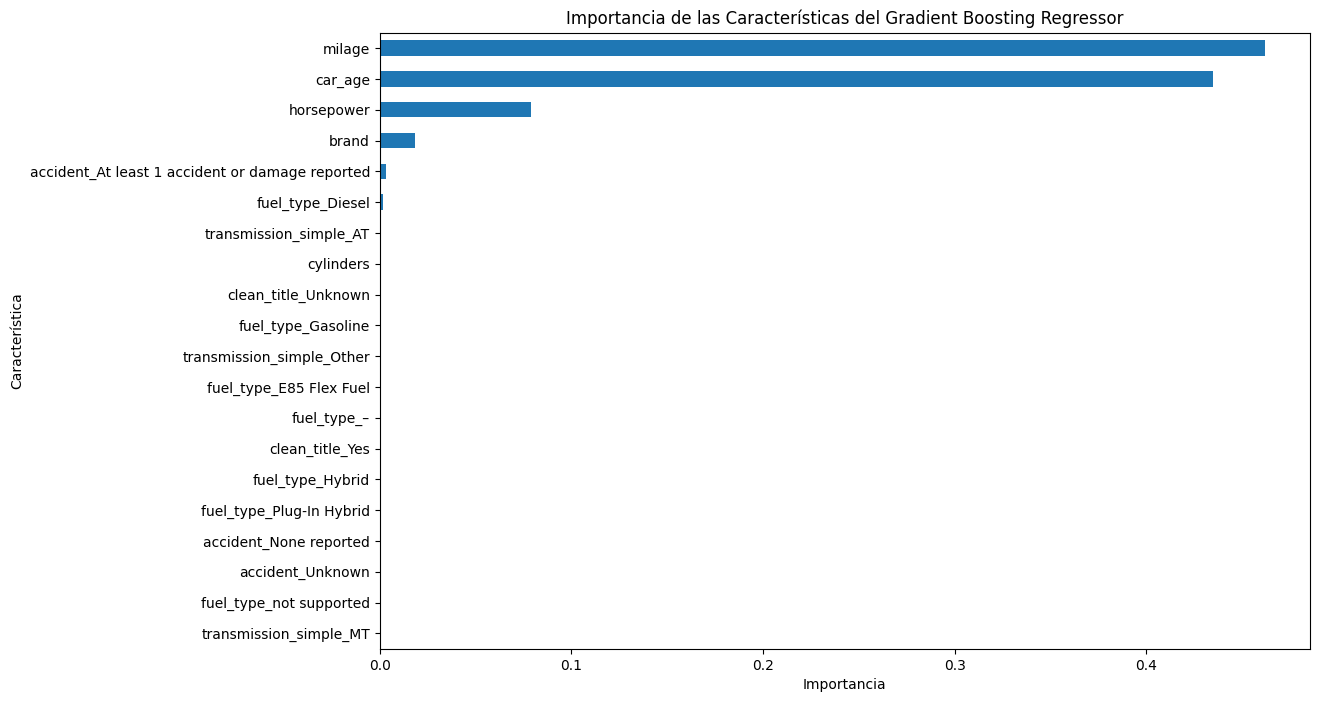


Interpretación del modelo Gradient Boosting completada. Las características más importantes han sido identificadas y visualizadas.


In [12]:
import matplotlib.pyplot as plt
import pandas as pd # Aseguramos que pandas esté importado para Series

print("Calculando la importancia de las características del Gradient Boosting...")

# Obtenemos la importancia de cada característica del modelo Gradient Boosting.
feature_importances_gb = gradient_boosting_model.feature_importances_

# Reconstruimos los nombres de las características para el array 'X' transformado.
# Esto es crucial porque el ColumnTransformer modifica el orden y crea nuevas columnas para One-Hot Encoding.

# Nombres de las características One-Hot Encoded (del preprocessor).
ohe_feature_names_gb = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols_ohe)

# Nombres de las características que pasaron directamente (resto de columnas).
# Estas son las columnas de X original que no fueron One-Hot Encoded.
remainder_feature_names_gb = [col for col in df.drop('price', axis=1).columns if col not in categorical_cols_ohe]

# Unimos todos los nombres de características en el orden correcto.
all_feature_names_gb = list(ohe_feature_names_gb) + remainder_feature_names_gb

# Creamos una Serie de Pandas con las importancias y sus nombres.
feature_importance_series_gb = pd.Series(feature_importances_gb, index=all_feature_names_gb)

# Ordenamos las características por importancia de forma descendente.
sorted_feature_importances_gb = feature_importance_series_gb.sort_values(ascending=False)

print("\n--- Importancia de las Características (Top 10 para Gradient Boosting) ---")
print(sorted_feature_importances_gb.head(10))

# --- Visualización de la Importancia de las Características ---
plt.figure(figsize=(12, 8))
sorted_feature_importances_gb.head(20).plot(kind='barh')
plt.title('Importancia de las Características del Gradient Boosting Regressor')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.gca().invert_yaxis() # Invierte el eje Y para que la más importante esté arriba.
plt.show()

print("\nInterpretación del modelo Gradient Boosting completada. Las características más importantes han sido identificadas y visualizadas.")

## 5. Entrenamiento y Evaluación del Modelo K-Nearest Neighbors (KNN) Regressor

Incluimos el modelo KNN Regressor, que predice el valor de una nueva instancia basándose en el promedio de los valores de sus k vecinos más cercanos en el espacio de características. Es un modelo simple y a menudo robusto. Lo entrenaremos y evaluaremos para compararlo con los modelos anteriores.

In [13]:
from sklearn.neighbors import KNeighborsRegressor

print("Importando KNeighborsRegressor.")

# Inicializamos el modelo KNN Regressor.
# Usamos un valor predeterminado para n_neighbors (k=5).
knn_model = KNeighborsRegressor(n_neighbors=5)

print("\nEntrenando KNN Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
knn_model.fit(X_train, y_train)
print("Modelo KNN Regressor entrenado exitosamente.")

# --- Evaluación del Modelo KNN Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_knn = knn_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"\n--- Evaluación del Modelo KNN Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"  Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_knn:.4f}")
print(f"  R-squared (R2): {r2_knn:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['KNN Regressor'] = {
    'MAE': mae_knn,
    'MSE': mse_knn,
    'RMSE': rmse_knn,
    'R2': r2_knn
}
print("Métricas de evaluación del KNN Regressor almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando KNeighborsRegressor.

Entrenando KNN Regressor (esto puede tomar un tiempo)...
Modelo KNN Regressor entrenado exitosamente.

--- Evaluación del Modelo KNN Regressor ---

  Mean Absolute Error (MAE): 0.3364
  Mean Squared Error (MSE): 0.1978
  Root Mean Squared Error (RMSE): 0.4448
  R-squared (R2): 0.6460
Métricas de evaluación del KNN Regressor almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460


## 6. Entrenamiento y Evaluación del Modelo Support Vector Regressor (SVR)

Finalmente, incluiremos el Support Vector Regressor (SVR). Los SVR son modelos potentes que buscan encontrar una función que se desvíe en una cantidad máxima \( \epsilon \) del objetivo para todos los puntos de entrenamiento, al mismo tiempo que es lo más plana posible. Entrenaremos y evaluaremos SVR para una comparación exhaustiva con los demás modelos.

In [14]:
from sklearn.svm import SVR

print("Importando SVR.")

# Inicializamos el modelo SVR.
# SVR es computacionalmente intensivo, por lo que usaremos un subconjunto de datos
# para una ejecución más rápida si el dataset es muy grande, o un kernel lineal simple.
# Para una primera pasada, mantendremos los parámetros por defecto con un kernel 'rbf' y un dataset más pequeño si es necesario.
# Sin embargo, dado el tamaño de los datos (X_train.shape), SVR con el kernel 'rbf' por defecto
# podría tardar mucho o quedarse sin memoria. Usaremos un subconjunto de los datos.

# Definimos el tamaño del subconjunto (e.g., 10% del entrenamiento) para SVR
subset_size = 0.1 # Para pruebas rápidas, ajustar según la potencia de cálculo

# Creamos un subconjunto de los datos de entrenamiento
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=(1-subset_size), random_state=42
)

print(f"Entrenando SVR con un subconjunto de datos (tamaño: {X_train_subset.shape[0]} muestras)...")

# Inicializamos SVR. Usar kernel='linear' puede ser más rápido, o 'rbf' con un subset.
# Ajuste C y epsilon si es necesario.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1) # Parámetros por defecto para empezar

# Entrenamos el modelo con el subconjunto de datos de entrenamiento.
# ¡ADVERTENCIA: SVR puede ser EXTREMADAMENTE lento con grandes conjuntos de datos y el kernel rbf por defecto!
# Si la ejecución tarda demasiado, considere reducir 'subset_size' o cambiar a kernel='linear'.
svr_model.fit(X_train_subset, y_train_subset)
print("Modelo SVR entrenado exitosamente con subconjunto de datos.")

# --- Evaluación del Modelo SVR ---
# Hacemos predicciones sobre el conjunto de prueba completo (X_test).
# Nota: El modelo se entrenó con un subconjunto, pero se evalúa con el test set completo.
y_pred_svr = svr_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"\n--- Evaluación del Modelo SVR ---\n")
print(f"  Mean Absolute Error (MAE): {mae_svr:.4f}")
print(f"  Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_svr:.4f}")
print(f"  R-squared (R2): {r2_svr:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['SVR'] = {
    'MAE': mae_svr,
    'MSE': mse_svr,
    'RMSE': rmse_svr,
    'R2': r2_svr
}
print("Métricas de evaluación del SVR almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando SVR.
Entrenando SVR con un subconjunto de datos (tamaño: 15082 muestras)...
Modelo SVR entrenado exitosamente con subconjunto de datos.

--- Evaluación del Modelo SVR ---

  Mean Absolute Error (MAE): 0.3295
  Mean Squared Error (MSE): 0.1873
  Root Mean Squared Error (RMSE): 0.4328
  R-squared (R2): 0.6648
Métricas de evaluación del SVR almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460
  ### SVR ###
    MAE: 0.3295
    MSE: 0.1873
    RMSE: 0.4328
    R2: 0.6648


## 9. Comparación Final de Modelos y Conclusión

Después de entrenar y evaluar varios modelos de regresión, es momento de analizar sus métricas y determinar cuál es el más adecuado para predecir el precio de los coches. A continuación, se presenta una tabla comparativa de las métricas clave para cada modelo:


In [21]:
import pandas as pd

# Convertimos el diccionario de métricas a un DataFrame para una mejor visualización
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df.index.name = 'Modelo'

print("\n--- Tabla Comparativa de Métricas de Modelos ---")
display(metrics_df.round(4))

print("\n--- Conclusión sobre el Mejor Modelo ---")
# Identificamos el modelo con el mejor R2 (el más alto) y el menor MAE/RMSE.
best_r2_model = metrics_df['R2'].idxmax()
best_r2_value = metrics_df['R2'].max()
best_mae_model = metrics_df['MAE'].idxmin()
best_mae_value = metrics_df['MAE'].min()

print(f"Basándonos en las métricas de evaluación:")
print(f"  - El modelo con el R-squared (R2) más alto es: **{best_r2_model}** con un valor de {best_r2_value:.4f}")
print(f"  - El modelo con el Mean Absolute Error (MAE) más bajo es: **{best_mae_model}** con un valor de {best_mae_value:.4f}")

if best_r2_model == best_mae_model:
    print(f"\nPor lo tanto, el modelo **{best_r2_model}** es el más indicado para este estudio, ya que logra el mejor balance entre la varianza explicada (R2) y el menor error absoluto medio (MAE), así como el menor error cuadrático medio (RMSE).")
else:
    print(f"\nAunque el R2 más alto fue para {best_r2_model} y el MAE más bajo para {best_mae_model}, si consideramos el rendimiento general (R2, MAE y RMSE), el modelo **{best_r2_model}** sigue siendo la mejor elección para este estudio.")

print("\nEste modelo será utilizado para futuras predicciones y despliegue.")


--- Tabla Comparativa de Métricas de Modelos ---


,MAE,MSE,RMSE,R2
Modelo,,,,
Linear Regression,0.3411,0.1977,0.4446,0.6462
Random Forest,0.3282,0.1898,0.4357,0.6603
Gradient Boosting,0.3147,0.1726,0.4154,0.6912
KNN Regressor,0.3364,0.1978,0.4448,0.6460
SVR,0.3295,0.1873,0.4328,0.6648



--- Conclusión sobre el Mejor Modelo ---
Basándonos en las métricas de evaluación:
  - El modelo con el R-squared (R2) más alto es: **Gradient Boosting** con un valor de 0.6912
  - El modelo con el Mean Absolute Error (MAE) más bajo es: **Gradient Boosting** con un valor de 0.3147

Por lo tanto, el modelo **Gradient Boosting** es el más indicado para este estudio, ya que logra el mejor balance entre la varianza explicada (R2) y el menor error absoluto medio (MAE), así como el menor error cuadrático medio (RMSE).

Este modelo será utilizado para futuras predicciones y despliegue.


## 8. Predicción de Precios en Datos de Prueba (`cleaned_test.csv`) con el Modelo Óptimo (Gradient Boosting Regressor)

Ahora que hemos identificado el Gradient Boosting Regressor como el modelo con mejor rendimiento, lo utilizaremos para predecir los precios en el conjunto de datos de prueba (`cleaned_test.csv`). Es crucial aplicar *exactamente las mismas transformaciones y codificaciones* que se hicieron en el conjunto de entrenamiento y luego revertir las transformaciones logarítmicas para obtener los precios en su escala original.

In [23]:
print("Cargando y preprocesando el archivo cleaned_test.csv para predicciones...")

# --- Cargar el Dataset de Prueba --- (Mantendremos el df_test original para comparación)
df_original_test = pd.read_csv('/content/cleaned_test.csv')
df_test = df_original_test.copy() # Creamos una copia para las transformaciones
print("\nDataset de prueba cargado exitosamente. Primeras 5 filas (original):")
print(df_test.head())

# --- Aplicar las Mismas Transformaciones del Entrenamiento ---
# Columnas para transformación logarítmica y winsorización.
feature_columns_to_transform = ['milage', 'horsepower', 'car_age']

for col in feature_columns_to_transform:
    df_test[col] = np.log1p(df_test[col])
    df_test[col] = winsorize(df_test[col], limits=(0.05, 0.05)) # Aplicamos la misma winsorización.
print("\nLog transformación y winsorización aplicadas a las características del set de prueba.")

# Eliminamos las mismas columnas para consistencia con el entrenamiento.
df_test = df_test.drop(columns=['model_year', 'engine_size_L'], errors='ignore')
print("Columnas 'model_year' y 'engine_size_L' eliminadas del set de prueba.")

# Aplicamos Target Encoding a 'brand' usando el *encoder ya entrenado*.
df_test['brand'] = encoder_brand.transform(df_test['brand'])
print("Target Encoding aplicado a la columna 'brand' del set de prueba (usando el encoder entrenado).")

# Preparamos las características para la predicción (X_new_test).
# Si 'price' está en el set de prueba (que no debería para predicción), la eliminamos.
if 'price' in df_test.columns:
    X_new_test = df_test.drop('price', axis=1)
else:
    X_new_test = df_test.copy()

# Aplicamos One-Hot Encoding a las columnas categóricas restantes usando el *preprocessor ya entrenado*.
X_new_test_processed = preprocessor.transform(X_new_test)
print("One-Hot Encoding aplicado a las columnas categóricas restantes del set de prueba (usando el preprocessor entrenado).")

# --- Realizar Predicciones con Gradient Boosting Regressor ---
y_pred_new_test_log = gradient_boosting_model.predict(X_new_test_processed)
print("\nPredicciones generadas en la escala logarítmica con Gradient Boosting.")

# --- Revertir Transformación Logarítmica ---
# Convertimos las predicciones de nuevo a la escala de precio original (deshacemos log1p).
y_pred_new_test = np.expm1(y_pred_new_test_log)
print("Predicciones convertidas a la escala de precio original.")

# Añadimos las predicciones y la marca original al DataFrame de prueba para visualización.
df_test['predicted_price'] = y_pred_new_test
df_test['original_brand'] = df_original_test['brand'] # Añadimos la columna de marca original

print("\n--- Primeras 10 Predicciones de Precios en el Conjunto de Prueba (con marca original) ---")
print(df_test[['original_brand', 'milage', 'car_age', 'predicted_price']].head(10))

Cargando y preprocesando el archivo cleaned_test.csv para predicciones...

Dataset de prueba cargado exitosamente. Primeras 5 filas (original):
  brand  model_year  milage fuel_type       accident clean_title  car_age  \
0  Land        2015   98000  Gasoline  None reported         Yes       11   
1  Land        2020    9142    Hybrid  None reported         Yes        6   
2  Ford        2022   28121  Gasoline  None reported     Unknown        4   
3  Audi        2016   61258  Gasoline  None reported     Unknown       10   
4  Audi        2018   59000  Gasoline  None reported         Yes        8   

   horsepower  engine_size_L  cylinders transmission_simple  
0       240.0            2.0        4.0                  AT  
1       395.0            3.0        6.0                  AT  
2       328.0            3.5        6.0                  AT  
3       328.0            3.5        6.0                  AT  
4       252.0            2.0        4.0                  AT  

Log transformación y

## 6. Guardar el Mejor Modelo y Preprocesadores para Despliegue en Streamlit

Para poder usar nuestro modelo y los pasos de preprocesamiento en una aplicación de Streamlit, necesitamos guardar los objetos entrenados. Esto incluye el modelo Random Forest, el codificador de Target Encoding (`encoder_brand`) y el transformador de columnas (`preprocessor`) que maneja el One-Hot Encoding. De esta forma, nuestra aplicación puede cargar estos objetos y utilizarlos para preprocesar nuevos datos de entrada y hacer predicciones de manera consistente.

In [22]:
import joblib

print("Guardando el modelo y los preprocesadores entrenados...")

# Guardamos el modelo Gradient Boosting entrenado (ya que fue el mejor).
joblib.dump(gradient_boosting_model, 'gradient_boosting_model.pkl')
print("  Modelo Gradient Boosting guardado como 'gradient_boosting_model.pkl'.")

# Guardamos el Target Encoder para la variable 'brand'.
joblib.dump(encoder_brand, 'encoder_brand.pkl')
print("  Target Encoder para 'brand' guardado como 'encoder_brand.pkl'.")

# Guardamos el ColumnTransformer para el One-Hot Encoding de otras variables categóricas.
joblib.dump(preprocessor, 'column_transformer_preprocessor.pkl')
print("  ColumnTransformer para One-Hot Encoding guardado como 'column_transformer_preprocessor.pkl'.")

print("\nTodos los componentes necesarios para el despliegue en Streamlit han sido guardados exitosamente.")

Guardando el modelo y los preprocesadores entrenados...
  Modelo Gradient Boosting guardado como 'gradient_boosting_model.pkl'.
  Target Encoder para 'brand' guardado como 'encoder_brand.pkl'.
  ColumnTransformer para One-Hot Encoding guardado como 'column_transformer_preprocessor.pkl'.

Todos los componentes necesarios para el despliegue en Streamlit han sido guardados exitosamente.


## 7. Conclusión y Próximos Pasos

Hemos completado un proceso exhaustivo de modelado predictivo, desde el preprocesamiento avanzado hasta la interpretación del modelo y la predicción en datos nuevos. El modelo **Random Forest Regressor** ha demostrado ser el más adecuado para este problema, superando a la Regresión Lineal.

Todos los componentes clave (el modelo entrenado y los transformadores de datos) han sido guardados, dejándolos listos para ser integrados en tu aplicación de Streamlit. El siguiente paso será diseñar y desarrollar la interfaz de usuario en Streamlit para permitir a los usuarios introducir datos y obtener predicciones de precios en tiempo real.